In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image as pil_image

In [2]:
model = InceptionV3(weights='imagenet')

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
def get_dim_scale(scale_percent = 50, img = None):
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  return dim

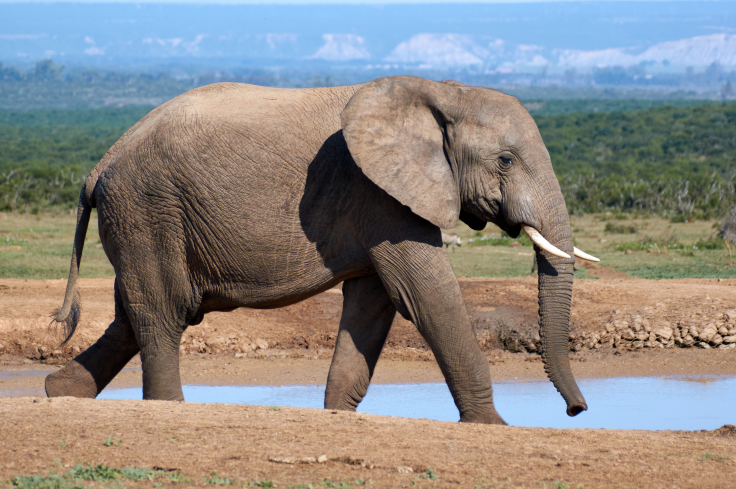

In [4]:
elephant_url = 'https://images.unsplash.com/photo-1597489204822-6f031f10f09d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8'

elephant_img = io.imread(elephant_url)

dim = get_dim_scale(15, elephant_img)
# resize image
elephant_img = cv2.resize(elephant_img, dim, interpolation = cv2.INTER_AREA)
elephant_img = cv2.cvtColor(elephant_img, cv2.COLOR_BGR2RGB)
cv2_imshow(elephant_img)

In [5]:
# Resize image to feed to the Inception network
img = cv2.resize(elephant_img, (299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print(decode_predictions(preds))

[[('n02504458', 'African_elephant', 0.8265192), ('n01871265', 'tusker', 0.08336864), ('n02504013', 'Indian_elephant', 0.055767436), ('n04049303', 'rain_barrel', 0.00020876112), ('n02391049', 'zebra', 0.00020111469)]]


The model predicts the image corresponds to an "**African_elephant**" with a probability of **0.83**.

# Grad-CAM

In [6]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_93')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

To visualize the heatmap we need to transform all the values between 0 and 1, and reshape to an `8x8` array.

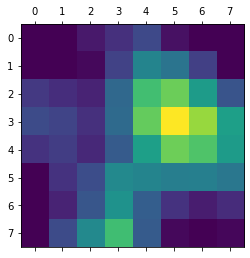

In [7]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((8, 8))
plt.matshow(heatmap)
plt.show()

Now let's cover the image with the heatmap. To do so, we need to resize the heatmap to match the shape of the image, so that it can properly impose it. The function `cv2.applyColorMap` permits to apply the heatmap to the image (multiply by 255 to convert it into RGB form). Also, multiply the heatmap by an intensity factor, depending on how much we want the heatmap to cover the image.

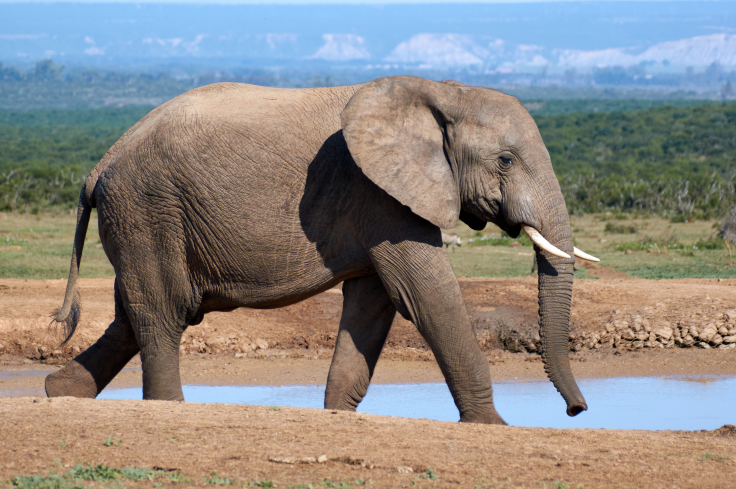

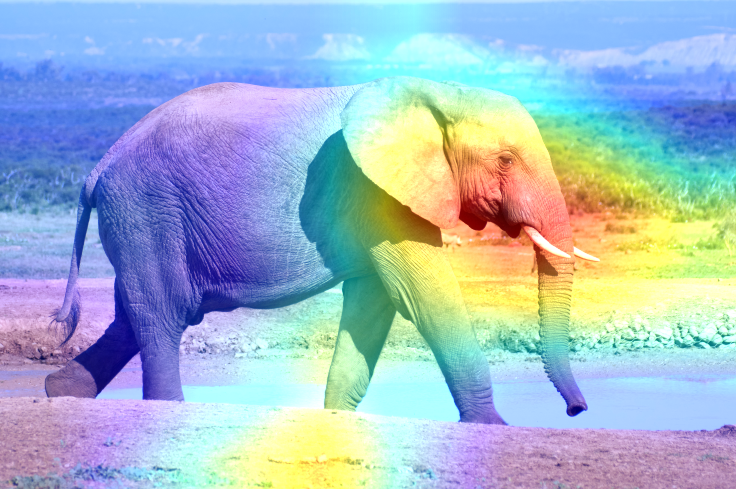

In [8]:
INTENSITY = 0.5

heatmap = cv2.resize(heatmap, (elephant_img.shape[1], elephant_img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
img = heatmap * INTENSITY + elephant_img

# Original image vs. image plus heatmap
cv2_imshow(elephant_img)
cv2_imshow(img)

It can be seen on the heatmap picture that the elephant's head "activated" the model more than the rest of the image.

Now let's compress all the code in a function and try it with other images.

Norfolk_terrier


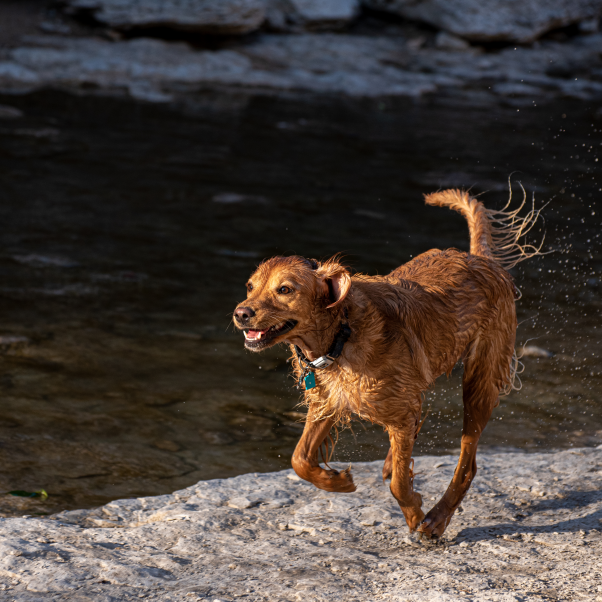

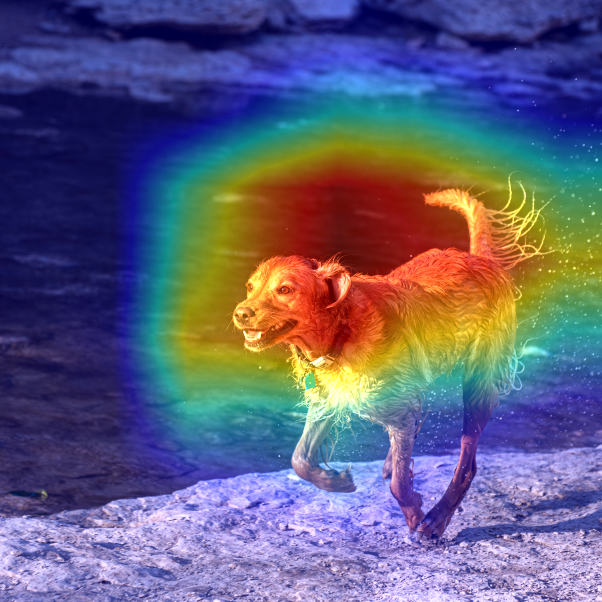

sandbar


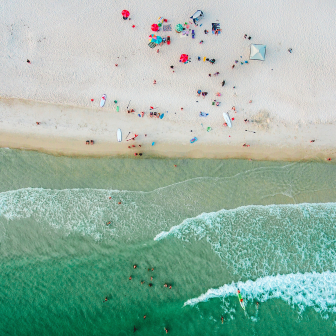

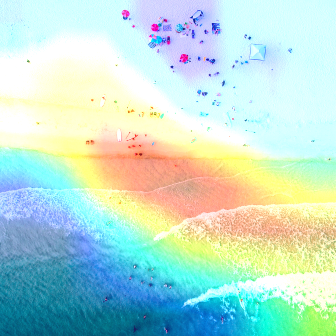

monitor


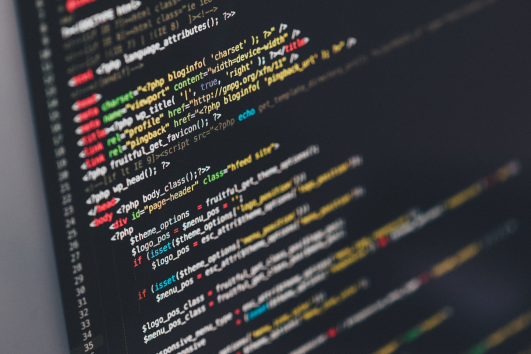

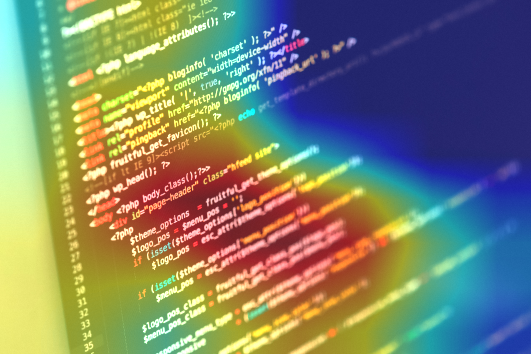

seashore


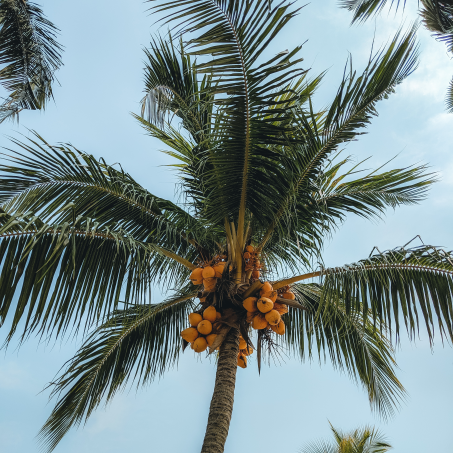

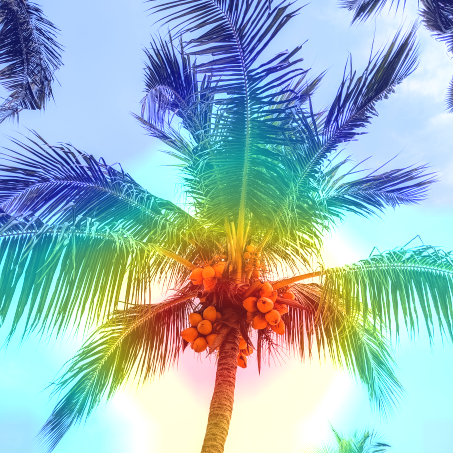

common_iguana


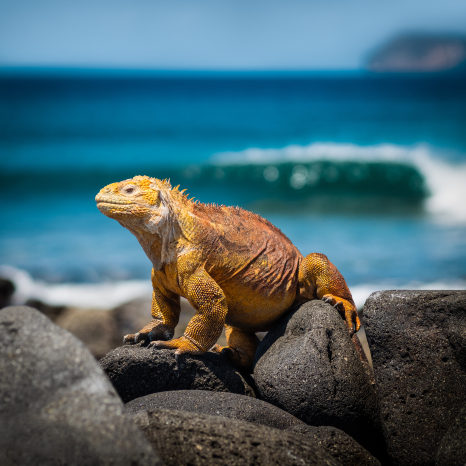

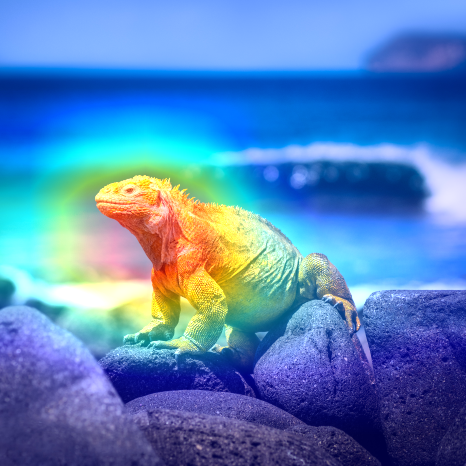

In [9]:
def gradCAM(image_source, img_scale_dim_factor, intensity=0.5):

  img = io.imread(image_source)
  dim = get_dim_scale(img_scale_dim_factor, img)
  # resize image
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  
  img_x = cv2.resize(img, (299, 299))
  x = image.img_to_array(img_x)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_93')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img_heatmap = heatmap * intensity + img

  # Original image vs. image plus heatmap
  cv2_imshow(img)
  cv2_imshow(img_heatmap)

gradCAM('https://images.unsplash.com/photo-1611359550677-81caada15ef9?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8', 15)
gradCAM('https://images.unsplash.com/photo-1504490705602-59c8ba99c467?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8', 15)
gradCAM('https://images.unsplash.com/photo-1461749280684-dccba630e2f6?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8', 15)
gradCAM('https://images.unsplash.com/photo-1569742460976-c91ebe40b0b2?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8', 15)
gradCAM('https://images.unsplash.com/photo-1503301360699-4f60cf292ec8?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8', 15)